In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import other relevant packages
import tweepy
import re
import math
import string
import pickle
from urllib.request import urlopen
from string import punctuation
from joblib import dump, load
from skimage import io
from wordcloud import WordCloud, STOPWORDS

# Import and download NLP functions
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Import sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Import estimators
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Import streamlined methodology methods
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
import joblib

[nltk_data] Downloading package punkt to /home/hanzala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hanzala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hanzala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hanzala/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
inputs = ['I love the world',
          'I hate the world',
          'I am indifferent about the world']

w = ['I', 'love', 'hate', 'am', 'indifferent', 'about', 'the', 'world']
m = [[1, 1, 0, 0, 0, 0, 1, 1],
     [1, 0, 1, 0, 0, 0, 1, 1],
     [1, 0, 0, 1, 1, 1, 1, 1]]
pd.DataFrame(m, columns=w)

tf = TfidfTransformer()
m = tf.fit_transform(m).todense()
pd.DataFrame(m, columns=w)

,I,love,hate,am,indifferent,about,the,world
0,0.412859,0.69903,0.00000,0.00000,0.00000,0.00000,0.412859,0.412859
1,0.412859,0.00000,0.69903,0.00000,0.00000,0.00000,0.412859,0.412859
2,0.293607,0.00000,0.00000,0.49712,0.49712,0.49712,0.293607,0.293607


In [4]:
def print_balance(df, col='senti'):
    if type(df) == pd.DataFrame:
        counts = df[col].value_counts(normalize=True)
    else:
        labels, counts = np.unique(y_test, return_counts=True)
        counts = dict(zip(labels, counts / len(y_test)))

    print(f'This dataset contains {int(counts[0]*len(df))} negative tweets ({counts[0]})')
    print(f'This dataset contains {int(counts[2]*len(df))} neutral tweets ({counts[2]})')
    print(f'This dataset contains {int(counts[4]*len(df))} positive tweets ({counts[4]})')
    return counts

def balance(df, col='senti', weights=(1, 1, 1)):
    # Get the number of observations with each classification
    counts = df[col].value_counts(normalize=True)

    # Get the smallest number of observations for a sentiment label
    minNum = int(counts.min() * len(df))

    # Split the observations by sentiment and keep the same number of observations for each
    df_neg = df[df.senti == 0].iloc[:int(minNum*weights[0]), :]
    df_neu = df[df.senti == 2].iloc[:int(minNum*weights[1]), :]
    df_pos = df[df.senti == 4].iloc[:int(minNum*weights[2]), :]

    # Combine observations back into one dataframe 
    df_bal = pd.concat([df_neg, df_neu, df_pos])
    return df_bal

def clean_sentiment(s):
    '''
    This function cleans the sentiment label for tweets in the Sanders Analytics dataset.
    
    Inputs: string (sentiment label : {'negative', 'neutral', 'positive'})
    Outputs: integer (sentiment label : {0, 2, 4})
    '''
    if s == 'positive':
        return 4
    elif s == 'negative':
        return 0
    else:
        return 2

def preprocessTweets(text):
    text = str(text)
    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    return text


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=SVC()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [5]:
data1 = pd.read_csv('./data/FinalizedFull.csv').rename(columns={'tweet':'text'})
data1.head()

,text,senti
0,@united UA5396 can wait for me. I'm on the gro...,0
1,I hate Time Warner! Soooo wish I had Vios. Can...,0
2,"@united Oh, we are sure it's not planned, but ...",0
3,Tom Shanahan's latest column on SDSU and its N...,2
4,Found the self driving car!! /IWo3QSvdu2,2


In [6]:
# Check the balance of the dataset
counts1 = print_balance(data1)

This dataset contains 377 negative tweets (0.3781344032096289)
This dataset contains 239 neutral tweets (0.23971915747241726)
This dataset contains 381 positive tweets (0.38214643931795383)


In [7]:
# Read in the dataset
data2 = pd.read_csv('./data/full-corpus.csv')[['Sentiment', 'TweetText']].rename(columns={'Sentiment':'senti', 'TweetText':'text'})

# Drop all spanish observations
data2 = data2[data2.senti != 'irrelevant']

# Clean the sentiment labels
data2['senti'] = data2['senti'].apply(clean_sentiment)

data2.head()

,senti,text
0,4,Now all @Apple has to do is get swype on the i...
1,4,@Apple will be adding more carrier support to ...
2,4,Hilarious @youtube video - guy does a duet wit...
3,4,@RIM you made it too easy for me to switch to ...
4,4,I just realized that the reason I got into twi...


In [8]:
# Check the balance of the dataset
counts2 = print_balance(data2)

This dataset contains 572 negative tweets (0.16705607476635514)
This dataset contains 2333 neutral tweets (0.6813668224299065)
This dataset contains 519 positive tweets (0.15157710280373832)


In [9]:
# Concatenate both training sets and preprocess tweets
train = pd.concat([data1, data2])
train['text'] = train['text'].apply(preprocessTweets)

# Check the balance of the dataset
train_counts = print_balance(train)

This dataset contains 949 negative tweets (0.21465731734901605)
This dataset contains 2572 neutral tweets (0.5817688305813165)
This dataset contains 900 positive tweets (0.2035738520696675)


In [10]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train.text.values, train.senti.values, random_state=637)

In [11]:
# Split the test set into two equal parts
X_test_bal, X_test_full, y_test_bal, y_test_full = train_test_split(X_test, y_test, test_size=0.5, random_state=637)

# See composition of unbalanced test set
print('\033[1mComposition of unbalanced test set:\033[0m')
print_balance(y_test_full)

# Create the balanced dataframe
test_bal = pd.DataFrame({'text':X_test_bal, 'senti':y_test_bal})
test_bal = balance(test_bal)
print('\n\033[1mComposition of balanced test set:\033[0m')
print_balance(test_bal)

X_test_bal = test_bal.text.values
y_test_bal = test_bal.senti.values

Composition of unbalanced test set:
This dataset contains 111 negative tweets (0.20162748643761302)
This dataset contains 327 neutral tweets (0.5913200723327305)
This dataset contains 114 positive tweets (0.2070524412296564)

Composition of balanced test set:
This dataset contains 114 negative tweets (0.3333333333333333)
This dataset contains 114 neutral tweets (0.3333333333333333)
This dataset contains 114 positive tweets (0.3333333333333333)


In [12]:
class TwitterSentimentModel():

    def __init__(self):
        pass

    def fit(self, X, y, classifier='all', cv=10, verbose=False):

        X = [preprocessTweets(t) for t in X]

        # Create the Pipeline object
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
            ('clf', ClfSwitcher())
        ])

        # this is where we define the values for GridSearchCV to iterate over
        parameters = [
            { # For SVM, the best accuracy was 70.67% on the test data (71.36% on training data) -- runs in about 60 sec
             'clf__estimator': [SVC(random_state=637)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__kernel' : ['rbf', 'linear', 'sigmoid'],
            },
            { # For Naive Bayes, the best accuracy was 68.30% on the test data (70.12% on training data) -- runs in about 5.1 sec
             'clf__estimator': [MultinomialNB()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            { # For KNN, the best accuracy was 62.96% on the test data (64.25% on training data) -- runs in about 35.3 sec
             'clf__estimator': [KNeighborsClassifier()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__leaf_size': [10, 30, 50],
             'clf__estimator__n_neighbors' : [1, 5, 10, 20]
            },
             { # For Random Forests, the best accuracy was 68.30% on the test data (69.13% on training data) -- runs in about 1.7 min (102 sec)
             'clf__estimator': [RandomForestClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__criterion' : ['gini', 'entropy'],
             'clf__estimator__min_samples_leaf' : [1, 5],
             'clf__estimator__max_depth' : [5, 25, None]
            },
            { # For Logistic Regression, the best accuracy was 69.48% on the test data (70.12% on training data) -- runs in about 14.1 sec
             'clf__estimator': [LogisticRegression(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__C' : np.arange(0.5, 1.5, 11)
            }]
        
        param_dict = {
            'SVM' : 0, 
            'Naive Bayes' : 1,
            'KNN' : 3,
            'Random Forest' : 4,
            'Logistic Regression' : 6
        }

        if classifier != 'all':
            parameters = parameters[param_dict[classifier]]
        else:
            pass

        # do 10-fold cross validation for each of the combinations of the above params
        self.grid = GridSearchCV(pipeline, cv=cv, param_grid=parameters, n_jobs=-1, verbose=1)
        self.grid.fit(X, y)
         # summarize results
        print("\nBest Model: {0:.2%} using {1}".format(self.grid.best_score_, self.grid.best_params_))
        print('\n')
        self.compile_results(X, y)


    def compile_results(self, X, y):
        self.means = self.grid.cv_results_['mean_test_score']
        self.stds = self.grid.cv_results_['std_test_score']
        self.params = self.grid.cv_results_['params']

        # Define the estimator tested
        estimators = {
            SVC : 'SVC',
            MultinomialNB : 'Naive Bayes',
            KNeighborsClassifier : 'KNN',
            RandomForestClassifier : 'Random Forest',
            LogisticRegression : 'Logistic Regression'
        }

        # Organize the estimator performance into a data frame
        data = {
            'Estimator':[estimators[type(e['clf__estimator'])] for e in self.params],
            'score': self.means,
            'ngram_range': [e['tfidf__ngram_range'] for e in self.params],
            'tfidf__norm' : [e['tfidf__norm'] for e in self.params],
            'computing_time' : self.grid.cv_results_['mean_fit_time'],
            'estimator_obj' : [e['clf__estimator'] for e in self.params]
        }

        self.all_results = pd.DataFrame(data=data)

        # Get the best performing model for each estimator
        idx = self.all_results.groupby(['Estimator'])['score'].transform(max) == self.all_results['score']
        self.results = self.all_results[idx]
        idx = self.results.groupby(['Estimator'])['computing_time'].transform(max) == self.results['computing_time']
        self.results = self.results[idx].set_index('Estimator')


    def set_uncertainty(self, X, y):
        # Find the standard error on aggregate sentiment scores
        print('Calculating uncertainty for aggregate sentiment scores...')
        self.agg_errs, self.agg_true_means, self.agg_pred_means = self.agg_sent_score(X, y,
                                                                                      n_bootstraps=1000,
                                                                                      bootstrap_size=1000,
                                                                                      verbose=True)
        self.agg_me = self.agg_errs.mean()     # Mean average error in aggregated sentiment scores
        self.agg_unc = model.agg_errs.std()*2  # Uncertainty in aggregated sentiment scores (95% confidence)
        print('Done! Aggregate sentiment uncertainty = {0:.4f}'.format(self.agg_unc))


    def print_all_results(self):
        for mean, stdev, param in zip(self.means, self.stds, self.params):
            param = param.copy()
            del param['clf__estimator']
            print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


    def score(self, X, y, verbose=False):
        return self.grid.score(X, y)


    def predict(self, X, vebose=False):
        return self.grid.predict(X)


    def predict_proba(self, X):
        return self.grid.predict_proba(X)


    def predict_agg(self, X, verbose=False):
        agg_sent = ((self.grid.predict(X) - 2) / 2).mean()
        agg_unc = self.agg_unc * np.sqrt(1000 / len(X))
        if verbose: print('(scale from -1 to 1) Aggregated sentiment score: {0:.2f} \u00B1 {1:.2f}\n'.format(agg_sent, agg_unc))
        return agg_sent, self.agg_unc


    def classification_report(self, X, y):
        y_preds = self.predict(X)
        print(classification_report(y, y_preds))


    def confusion_matrix(self, X, y):
        y_preds = self.predict(X)
        print('\nconfusion matrix: \n',confusion_matrix(y,y_preds), '\n')


    def estimator_performance(self, metric='score', ylim=(0.6, 0.75)):
        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))
        self.results.sort_values(by=metric, ascending=False).plot.bar(y=metric, ax=ax, rot=45, legend=False)
        ax.set_ylim(ylim)
        ax.set_title('Model Performance for Each Estimator', fontsize='x-large')
        ax.set_xlabel('Estimator Type', fontsize='x-large')

        if metric == 'score':
            ax.set_ylabel('Max model accuracy', fontsize='x-large')
        elif metric == 'computing_time':
            ax.set_ylabel('Mean time to fit model (s)', fontsize='x-large')
        else:
            pass
        fig.show()
        return fig

    def sentiment_performance(self, X, y, ylim=0.5):
        # Get results
        report = classification_report(y, self.predict(X), output_dict=True)
        neg_results = list(report['0'].values())[:3]
        neu_results = list(report['2'].values())[:3]
        pos_results = list(report['4'].values())[:3]

        # Set position of bar on X axis
        barWidth = 0.25
        x1 = np.arange(len(neg_results))
        x2 = [x + barWidth for x in x1]
        x3 = [x + barWidth for x in x2]

        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))

        # Make the plot
        ax.bar(x1, neg_results, color='indianred', width=barWidth, edgecolor='white', label='Negative')
        ax.bar(x2, neu_results, color='sandybrown', width=barWidth, edgecolor='white', label='Neutral')
        ax.bar(x3, pos_results, color='mediumseagreen', width=barWidth, edgecolor='white', label='Postiive')
        ax.set_xticks(x2)
        ax.set_xticklabels(('Precision', 'Recall', 'F1 Score'), fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Best Estimator Performance on Different Sentiments', fontsize='x-large')

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        fig.show()
        return report


    def plot_roc(self, X_test, y_test):
        y_score = self.predict_proba(X_test)

        # Reshape y_test
        ytest = []
        for i in y_test:
            if i == 0:
                ytest.append([1, 0, 0])
            elif i == 2:
                ytest.append([0, 1, 0])
            else:
                ytest.append([0, 0, 1])
        y_test = np.array(ytest)
   
     # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        fig, ax = plt.subplots(figsize=(7, 7))
        for i, title in enumerate(['Negative', 'Neutral', 'Positive']):
            ax.plot(fpr[i], tpr[i], label=title + ' tweets (AUC = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Negative Rate', fontsize='x-large')
        ax.set_ylabel('True Positive Rate', fontsize='x-large')
        ax.set_title('ROC Curve of Each Sentiment', fontsize='xx-large')
        ax.legend(loc="lower right")
        fig.show()
        return fig


    def agg_sent_score(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        np.random.seed(637)
        true_means, pred_means, errs = np.ones(n_bootstraps), np.ones(n_bootstraps), np.ones(n_bootstraps)
        for i in range(n_bootstraps):
            if verbose:
                if not (i+1)%(n_bootstraps//5): print('{0:.0f}% done'.format((i+1)/(n_bootstraps//100)))
            ind = np.random.randint(0, len(X), int(bootstrap_size))
            X_boot = X[ind]
            y_boot = y[ind]
            y_pred = self.grid.predict(X_boot)

            # Standardize predictions to a -1 to 1 scale
            y_boot = (y_boot - 2) / 2
            y_pred = (y_pred - 2) / 2
            

            true_means.put(i, y_pred.mean())
            pred_means.put(i, y_boot.mean())
            errs.put(i, y_boot.mean() - y_pred.mean())

        self.mean_agg_error = errs.mean()
        return errs, true_means, pred_means


    def agg_sent_hist(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.hist(errs)
        plt.axvline(errs.mean(), color='k', linestyle='dashed')
        ax.set_xlabel('Aggregated Sentiment Error', fontsize='xx-large')
        ax.set_title('Sentiment Score Prediction Error', fontsize='xx-large')
        fig.show()
        return fig


    def agg_sent_plot(self, X, y, n_bootstraps=1000, bootstrap_size=1000, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.scatter(true_means, pred_means)
        ax.plot(true_means, true_means, color='red')
        ax.set_ylabel('Predicted Sentiment Score', fontsize='xx-large')
        ax.set_xlabel('Actual Sentiment Score', fontsize='xx-large')
        fig.show()
        return fig

    def word_cloud(self, tweets, labels=None, sentiment=None, showfig=True, mask=None, ngrams_range=(1, 2)):
        sent_dict = {'negative':0,
                    'neutral':2,
                    'positive':4}

        tweets = [preprocessTweets(tweet) for tweet in tweets]
        if labels is None:
            labels = self.predict(tweets)

        # Get desired tweets
        if sentiment:
            tweets = [tweets[i] for i in np.where(labels == sent_dict[sentiment])[0]]

        # Get vocabulary of tweets
        tfidf = TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english',
                                ngram_range=ngrams_range)
        tfidf.fit(tweets)
        
        vocabulary = tfidf.vocabulary_
        weights = tfidf.idf_
        weight_dict = {v:w for v, w, in zip(vocabulary, weights)}

        # Create Word Cloud
        word_cloud = WordCloud(width=2000,
                                height=1000,
                                max_font_size=200, 
                                background_color="white",
                                max_words=100,
                                mask=mask,
                                contour_width=1,
                                stopwords=STOPWORDS.add('https'))
        word_cloud.generate_from_frequencies(weight_dict)

        # Plot the Word Cloud
        fig = plt.figure(figsize=(10,10))
        plt.imshow(word_cloud, interpolation="hermite")
        plt.axis("off")     
        if showfig: fig.show()
        return fig

In [14]:
# if False:
model = TwitterSentimentModel()
# model.fit(X_train, y_train, classifier='SVC')
model.fit(X_train, y_train)
model.set_uncertainty(X_test, y_test)

with open("trained_model.pickle", "wb") as f:
    pickle.dump(model, f)

Fitting 10 folds for each of 96 candidates, totalling 960 fits

Best Model: 75.69% using {'clf__estimator': SVC(kernel='linear', random_state=637), 'clf__estimator__kernel': 'linear', 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


Calculating uncertainty for aggregate sentiment scores...
20% done
40% done
60% done
80% done
100% done
Done! Aggregate sentiment uncertainty = 0.0347


In [15]:
model_location = './trained_model.pickle'
model = load(model_location)

In [16]:
acc = model.score(X_test_full, y_test_full), model.score(X_test_bal, y_test_bal) 
print('accuracy on original test set: {0:.2%}'.format(acc[0])) 
print('accuracy on balanced test set: {0:.2%}'.format(acc[1])) 

accuracy on original test set: 78.30%
accuracy on balanced test set: 69.30%


In [17]:
fig = model.plot_roc(X_test, y_test)
fig.savefig('roc.png')

AttributeError: predict_proba is not available when  probability=False

/tmp/ipykernel_56408/3753770813.py:276: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Mean aggregate score error: 0.01892


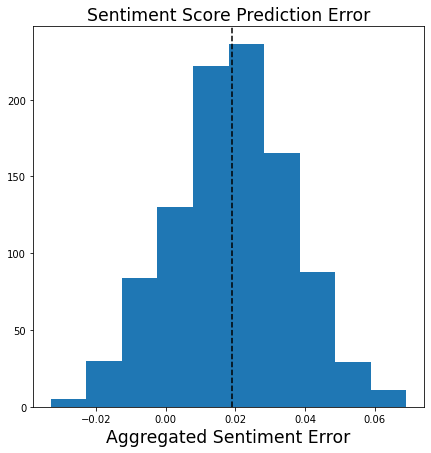

In [18]:
fig = model.agg_sent_hist(X_test, y_test)
print('Mean aggregate score error: {0:.5f}'.format(model.agg_me))
fig.savefig('agg_error_hist.png')

/tmp/ipykernel_56408/3753770813.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


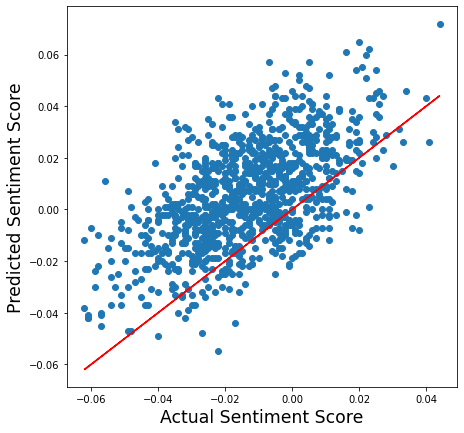

In [19]:
fig = model.agg_sent_plot(X_test, y_test)
fig.savefig('agg_error_scatter.png')

/tmp/ipykernel_56408/3753770813.py:201: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


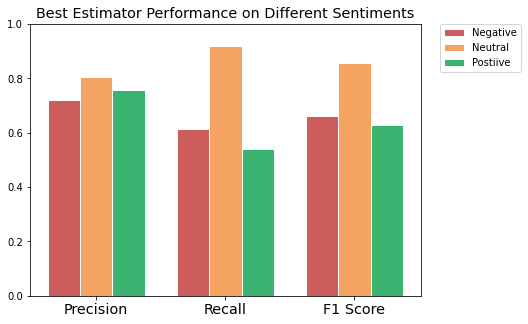

In [20]:
result_dict = model.sentiment_performance(X_test_full, y_test_full)

In [21]:
print('\033[1m\tClassification report on the Original Test Set\033[0m')
model.classification_report(X_test_full, y_test_full)

#print('\n\n\033[1m\tClassification report on the Balanced Test Set\033[0m')
#model.classification_report(X_test_bal, y_test_bal);

	Classification report on the Original Test Set
              precision    recall  f1-score   support

           0       0.72      0.62      0.66       104
           2       0.80      0.92      0.86       334
           4       0.76      0.54      0.63       115

    accuracy                           0.78       553
   macro avg       0.76      0.69      0.72       553
weighted avg       0.78      0.78      0.77       553



/tmp/ipykernel_56408/3753770813.py:172: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


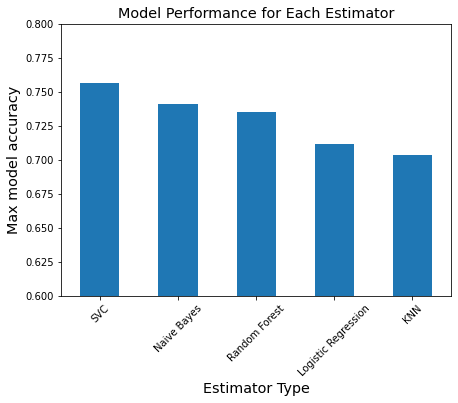

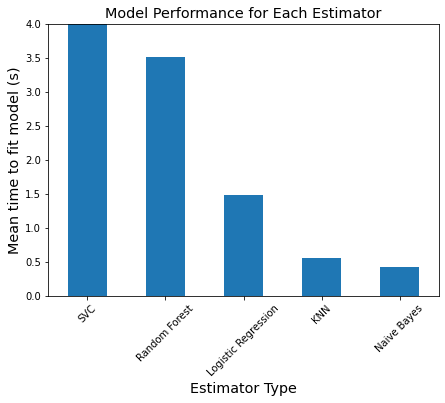

In [22]:
fig = model.estimator_performance('score', ylim=(0.6, 0.8))
fig.savefig('estimator_performance.png')

fig = model.estimator_performance('computing_time', ylim=(0, 4))
fig.savefig('estimator_time.png')